<a href="https://colab.research.google.com/github/chloelitrico/Deep-RNN/blob/master/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Deep Recurrent Neural Networks for Magnetic Resonance Fingerprinting**



In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

In [ ]:
#Data preprocessing

def preprocess(X1, X2, y):
  """
  Input: X and y values of imported data
  Output: normalized X values and scaled y values 
  """

  # Normalize input data
  X1 = normalize(X1)
  X2 = normalize(X2)

  #Scale Off resonance freqeuncy 
  y[:,2] = y[:, 2] *1000

  return X1, X2, y



# Cutom metrics 

def t1_MAPE(y_true, y_pred):
  difference = tf.math.divide(tf.math.abs(tf.math.subtract(y_true[:,0], y_pred[:,0])), y_true[:,0])
  t1_MAPE = tf.math.reduce_mean(difference)
  return t1_MAPE *100

def t2_MAPE(y_true, y_pred):
  difference = tf.math.divide(tf.math.abs(tf.math.subtract(y_true[:,1], y_pred[:,1])), y_true[:,1])
  t2_MAPE = tf.math.reduce_mean(difference)
  return t2_MAPE *100

def rf_MAPE(y_true, y_pred):
  # Account for divide-by-zero
  difference = tf.math.divide_no_nan(tf.math.abs(tf.math.subtract(y_true[:,2], y_pred[:,2])), tf.math.abs(y_true[:,2]))
  rf_MAPE = tf.math.reduce_mean(difference)
  return rf_MAPE *100

def t1_MAE(y_true, y_pred):
  difference = tf.math.abs(tf.math.subtract(y_true[:,0], y_pred[:,0]))
  t1_MAE = tf.math.reduce_mean(difference)
  return t1_MAE

def t2_MAE(y_true, y_pred):
  difference = tf.math.abs(tf.math.subtract(y_true[:,1], y_pred[:,1]))
  t2_MAE = tf.math.reduce_mean(difference)
  return t2_MAE

def rf_MAE(y_true, y_pred):
  difference = tf.math.abs(tf.math.subtract(y_true[:,2], y_pred[:,2]))
  rf_MAE = tf.math.reduce_mean(difference)
  return rf_MAE

def t1_RMSE(y_true, y_pred):
  difference = tf.math.squared_difference(y_true[:,0], y_pred[:,0])
  t1_MAE = tf.math.sqrt(tf.math.reduce_mean(difference))
  return t1_MAE

def t2_RMSE(y_true, y_pred):
  difference = tf.math.squared_difference(y_true[:,1], y_pred[:,1])
  t2_MAE = tf.math.sqrt(tf.math.reduce_mean(difference))
  return t2_MAE

def rf_RMSE(y_true, y_pred):
  difference = tf.math.squared_difference(y_true[:,2], y_pred[:,2])
  rf_MAE = tf.math.sqrt(tf.math.reduce_mean(difference))
  return rf_MAE

def t1_accuracy(y_true, y_pred):
  t1_accuracy = 1-tf.math.reduce_mean(tf.math.abs(y_true[:,0]-y_pred[:,0])/(tf.math.abs(y_true[:,0])),axis=0)
  return t1_accuracy

def t2_accuracy(y_true, y_pred):
  t2_accuracy = 1-tf.math.reduce_mean(tf.math.abs(y_true[:,1]-y_pred[:,1])/(tf.math.abs(y_true[:,1])),axis=0)
  return t2_accuracy

def rf_accuracy(y_true, y_pred):
  # Account for divid-by-zero error
  rf_accuracy = 1-tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(y_true[:,2]-y_pred[:,2]),(tf.math.abs(y_true[:,2]))),axis=0)
  return rf_accuracy

def t1_MAEstdv(y_true, y_pred):
  t1_MAEstdv = tf.math.sqrt(tf.math.reduce_mean(tf.math.squared_difference((tf.math.abs(y_true[:,0]-y_pred[:,0])), t1_MAE(y_true, y_pred))))
  return t1_MAEstdv

def t2_MAEstdv(y_true, y_pred):
  t2_MAEstdv = tf.math.sqrt(tf.math.reduce_mean(tf.math.squared_difference((tf.math.abs(y_true[:,1]-y_pred[:,1])), t2_MAE(y_true, y_pred))))
  return t2_MAEstdv

def rf_MAEstdv(y_true, y_pred):
  rf_MAEstdv = tf.math.sqrt(tf.math.reduce_mean(tf.math.squared_difference((tf.math.abs(y_true[:,2]-y_pred[:,2])), rf_MAE(y_true, y_pred))))
  return rf_MAEstdv



# Noise

def noise(signal):
  """
  Input: signal in the form of an array of integers
  Output: signal with added 1% gaussian noise
  """
  stdv = np.std(signal)
  mu, sigma = 0, 0.01 # mean:0 and stdv:1%
  noise = np.random.normal(mu, sigma*stdv, np.shape(signal)) 
  
  return signal + noise



# Neural Network Models

def ANN_1(features = 2):
  """
  Fully connected neural network accepting imaginary signal values as input and outputs predicted t1 and t2 values
  Neural network: 1 dimensional input layer, Dense 300 (activation tanh), Dense 300 (activation tanh), 2 dimensional output layer (activation relu)
  """

  model = Sequential() 
  model.add(Dense(300, activation='tanh')) #first hidden layer with 300 nodes
  model.add(Dense(300, activation='tanh')) #second hidden layer
  model.add(Dense(features, activation='relu')) #output layer 

  keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer='adam', loss="mean_squared_error", metrics=['accuracy', t1_MAPE, t2_MAPE, t1_MAE, t2_MAE, t1_accuracy, t2_accuracy, t1_RMSE, t2_RMSE])

  return model


def ANN_2(features = 3):
  """
  Fully connected neural network accepting real and imaginary parts of the signal as input and outputs predicted t1, t2, off res values
  Neural network: 2 dimensional input layer, Dense 300 (activation tanh), Dense 300 (activation tanh), 3 dimensional output layer (activation linear)
  """

  input1 = keras.layers.Input(shape=(1000, ))
  input2 = keras.layers.Input(shape=(1000,))
  merged = keras.layers.Concatenate(axis=1)([input1, input2])
  dense1 = keras.layers.Dense(300, input_dim=2, activation=keras.activations.tanh)(merged)
  dense2 = keras.layers.Dense(300, activation=keras.activations.tanh)(dense1)
  output = keras.layers.Dense(features, activation='linear', use_bias=True)(dense2)

  keras.optimizers.Adam(learning_rate=0.001)

  model = keras.models.Model([input1, input2], output)
  model.compile(optimizer='adam', loss="mean_squared_error", metrics=['accuracy', t1_MAPE, t2_MAPE, rf_MAPE, t1_MAE, t2_MAE, rf_MAE, t1_accuracy, t2_accuracy, rf_accuracy, t1_RMSE, t2_RMSE, rf_RMSE])

  return model



# Data visualization

def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_'+metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.plot(epochs, train_metrics, 'b--')
  plt.plot(epochs, val_metrics, 'r-')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  plt.show()

def plot_accuracies(history, metrics):
  for metric in metrics:
    plt.plot(training.history[metric])
  
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(metrics)
  plt.show()

def plot_true_v_predicted(y_test, y_predicted):

  metrics = ['T1', 'T2', 'RF']
  i = 0
  while i < np.shape(y_test)[1] :
    x = np.linspace(np.min(y_test[:,i]), np.max(y_test[:,i]))
    plt.scatter(y_test[:,i], y_predicted[:,i])
    plt.plot(x, x + 0, '-r')
    plt.xlabel('Reference '+ metrics[i] +' (ms)')
    plt.ylabel('Estimated '+ metrics[i] +' (ms)')
    plt.show() 
    rmse = math.sqrt(mean_squared_error(y_test[:,i], y_predicted[:,i]))
    score = r2_score(y_test[:,i], y_predicted[:,i])
    print("RMSE:", rmse)
    print("R^2:", score)
    i+=1



# Brain phantoms

def brain_preprocess(phantom_re, phantom_im, phantom_rf):

  # Normalizing
  for i in range(len(phantom_re)):
    phantom_re[i] = normalize(phantom_re[i])
  for i in range(len(phantom_im)):
    phantom_im[i] = normalize(phantom_im[i])
  
  return phantom_re, phantom_im, phantom_rf*1000

def brain_noise(phantom):
  for i in range(len(phantom)):
    for j in range(len(phantom[i])):
      phantom[i][j] = noise(phantom[i][j])
  return phantom

def make_brain_predictions(phantom_re, phantom_im, model, features):
  
  y_predicted = []
  
  for i in range(len(phantom_re)):
    if (features == 2):
      y_predicted.append(model.predict([phantom_im[i]]))
    else:
      y_predicted.append(model.predict([phantom_re[i], phantom_im[i]]))

  return np.array(y_predicted)


def mask_brain(y_predicted):
  for i in range(np.shape(y_predicted)[2]):
    bg = y_predicted[0,0,i]
    for row in range(np.shape(y_predicted)[0]):
      for col in range(np.shape(y_predicted)[1]):
        if y_predicted[row,col,i] == bg:
          y_predicted[row,col,i] = 0
  return y_predicted


def show_brain(y_predicted, y_true):
  # Visualize
  for i in range(np.shape(y_predicted)[2]):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 12))
    ax1, ax2, ax3 = axes
    
    im1 = ax1.imshow(y_predicted[:,:,i], cmap='hot', interpolation='nearest')
    im2 = ax2.imshow(y_true[i,:,:], cmap='hot', interpolation='nearest')
    im3 = ax3.imshow(tf.math.abs(y_true[i,:,:]-y_predicted[:,:,i]), cmap='hot', interpolation='nearest')
  
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)
    plt.colorbar(im2, fraction=0.045, pad=0.05, ax=ax2)
    plt.colorbar(im3, fraction=0.045, pad=0.05, ax=ax3)

    fig.tight_layout()
  
def brain_accuracy(y_true, y_pred):
  accuracy = []
  for i in range(np.shape(y_true)[2]): 
    accuracy.append(1-tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(y_true[:,:,i]-y_pred[:,:,i]),(tf.math.abs(y_true[:,:,i])))))
  return np.array(accuracy)

def show_prediction_metrics(y_test, y_predicted, parameters =2):
  print('t1_MAPE: ', np.array(t1_MAPE(y_test, y_predicted)))
  print('t2_MAPE: ', np.array(t2_MAPE(y_test, y_predicted)))
  print('t1_MAE: ', np.array(t1_MAE(y_test, y_predicted)))
  print('t2_MAE: ', np.array(t2_MAE(y_test, y_predicted)))
  print('t1_RMSE: ', np.array(t1_RMSE(y_test, y_predicted)))
  print('t2_RMSE: ', np.array(t2_RMSE(y_test, y_predicted)))
  print('t1_accuracy: ', np.array(t1_accuracy(y_test, y_predicted)))
  print('t2_accuracy: ', np.array(t2_accuracy(y_test, y_predicted)))
  print('t1_MAEstdv: ', np.array(t1_MAEstdv(y_test, y_predicted)))
  print('t2_MAEstdv: ', np.array(t2_MAEstdv(y_test, y_predicted)))

  if parameters == 3:
    print('rf_MAPE: ', np.array(rf_MAPE(y_test, y_predicted)))
    print('rf_MAE: ', np.array(rf_MAE(y_test, y_predicted)))
    print('rf_RMSE: ', np.array(rf_RMSE(y_test, y_predicted)))
    print('rf_accuracy: ', np.array(rf_accuracy(y_test, y_predicted)))
    print('rf_MAEstdv: ', np.array(rf_MAEstdv(y_test, y_predicted)))


In [ ]:
#Import t1 t2 b0 dictionary and look up table from Matlab
with h5py.File('/content/drive/My Drive/Colab Notebooks/t1t2rfdict.mat', 'r') as file:
    dict_im = np.array((file['dict_im']))
    dict_re = np.array((file['dict_re']))
    lut = np.array((file['lut'])) 

# Import brain phantom
with h5py.File('/content/drive/My Drive/Colab Notebooks/brain_phantom.mat', 'r') as file:
    phantom_re = (np.array((file['phantom_re']))).transpose(1, 2, 0)
    phantom_im = (np.array((file['phantom_im']))).transpose(1, 2, 0)
    phantom_t1 = np.array((file['T1_phantom']))
    phantom_t2 = np.array((file['T2_phantom']))
    phantom_rf = np.array((file['df_phantom']))


# Data preprocessing 
dict_re, dict_im, lut = preprocess(dict_re, dict_im, lut)
phantom_re, phantom_im, phantom_rf= brain_preprocess(phantom_re, phantom_im, phantom_rf)

# Define model parameters
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
# ANN T1 & T2
X_train,X_test,y_train,y_test = train_test_split(dict_im,lut[:,:-1],test_size=0.2)

# Create a basic model instance
model = ANN_1(np.shape(y_train)[1])

# Training
training = model.fit(noise(X_train), y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.2)

#Save model and training history
model.save('/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_1.h5') 

#Convert the training history to a pandas DataFrame:     
hist_df = pd.DataFrame(training.history) 

#Save to csv: 
hist_csv_file = '/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_1_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#Plot training metrics
plot_metric(training, 't1_accuracy')
plot_metric(training, 't2_accuracy')
plot_accuracies(training, ['t1_accuracy', 't2_accuracy']) 

1821/1821 [==============================] - 2s 1ms/step


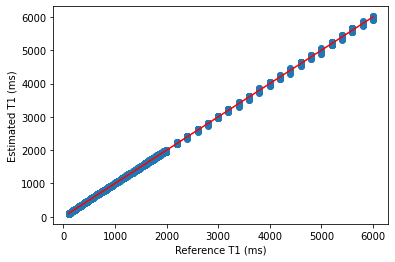

RMSE: 7.319664942722737
R^2: 0.9999790337783524


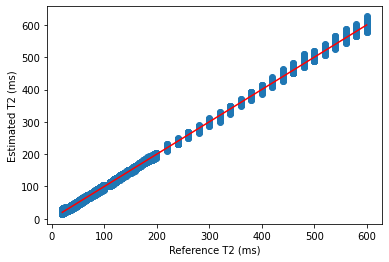

RMSE: 2.8175879036315745
R^2: 0.9996596722915806
t1_MAPE:  0.5114494083777571
t2_MAPE:  2.2021108686921735
t1_MAE:  4.824301527025378
t2_MAE:  2.031468975820807
t1_RMSE:  7.319664942722737
t2_RMSE:  2.8175879036315745
t1_accuracy:  0.9948855059162224
t2_accuracy:  0.9779788913130782
t1_MAEstdv:  5.504871447187923
t2_MAEstdv:  1.9524178330901745
[0.9974623 0.9928962]


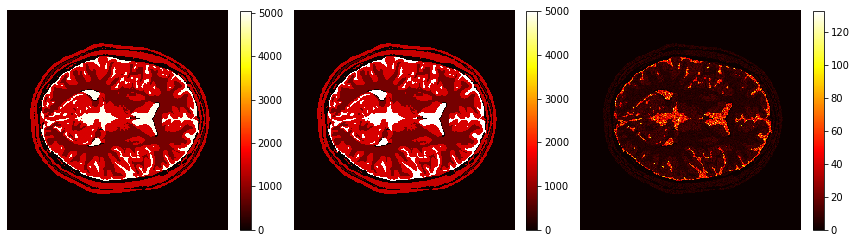

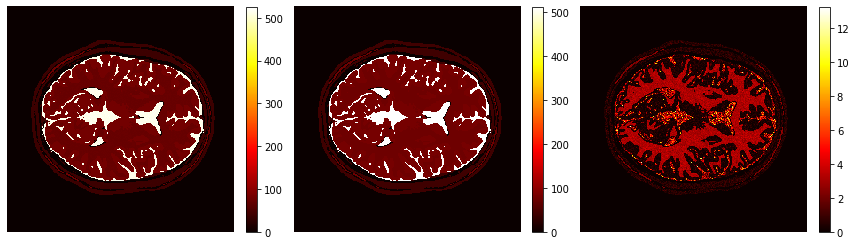

In [ ]:
# Testing
#model = load_model('/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_1.h5', custom_objects={'t1_MAPE':t1_MAPE, 't2_MAPE':t2_MAPE, 't1_MAE':t1_MAE, 't2_MAE':t2_MAE, 't1_accuracy':t1_accuracy, 't2_accuracy':t2_accuracy, 't1_RMSE':t1_RMSE, 't2_RMSE':t2_RMSE})
y_predicted = model.predict(X_test, verbose=1) 
plot_true_v_predicted(y_test, y_predicted)
show_prediction_metrics(y_test, y_predicted)

y_predicted = make_brain_predictions(brain_noise(phantom_re), brain_noise(phantom_im), model, 2)
y_predicted = mask_brain(y_predicted)
show_brain(y_predicted, np.array([phantom_t1, phantom_t2]))
print(brain_accuracy(np.array([phantom_t1, phantom_t2]).transpose(1, 2, 0), y_predicted))

In [ ]:
#ANN T1, T2, and RF

X1_train,X1_test,X2_train,X2_test,y_train,y_test = train_test_split(dict_re,dict_im,lut,test_size=0.2)

# Create a basic model instance
model = ANN_2(np.shape(y_train)[1])

#Training
training = model.fit([noise(X1_train), noise(X2_train)], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

#Save model and training history
model.save('/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_2.h5') 

#Convert the training history to a pandas DataFrame:     
hist_df = pd.DataFrame(training.history) 

#Save to csv: 
hist_csv_file = '/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_2_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#Plot training metrics
plot_metric(training, 't1_accuracy')
plot_metric(training, 't2_accuracy')
plot_metric(training, 'rf_accuracy')
plot_accuracies(training, ['t1_accuracy', 't2_accuracy', 'rf_accuracy']) 


1821/1821 [==============================] - 2s 1ms/step


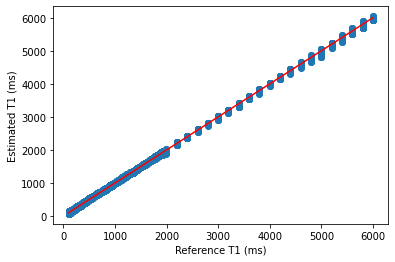

RMSE: 12.504402278464752
R^2: 0.9999388504701251


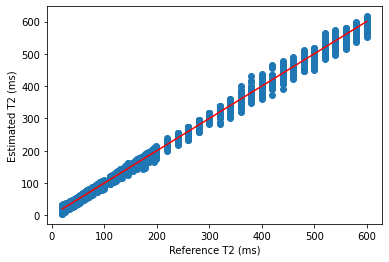

RMSE: 4.1995661686321375
R^2: 0.9992425354047451


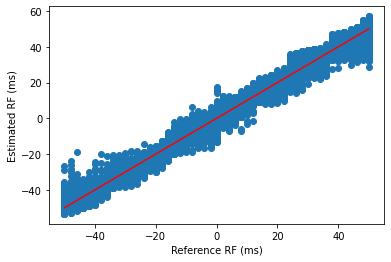

RMSE: 2.380203666655246
R^2: 0.9934053624805667
t1_MAPE:  1.0410810450814274
t2_MAPE:  2.9799362841583834
t1_MAE:  9.057318318543473
t2_MAE:  2.9493681266567555
t1_RMSE:  12.504402278464752
t2_RMSE:  4.1995661686321375
t1_accuracy:  0.9895891895491857
t2_accuracy:  0.9702006371584162
t1_MAEstdv:  8.621198363235317
t2_MAEstdv:  2.989579177439666
rf_MAPE:  12.87062346575451
rf_MAE:  1.6488448775194866
rf_RMSE:  2.380203666655246
rf_accuracy:  0.8712937653424548
rf_MAEstdv:  1.7165896611120628
[0.99519251 0.98943641 0.96958091]


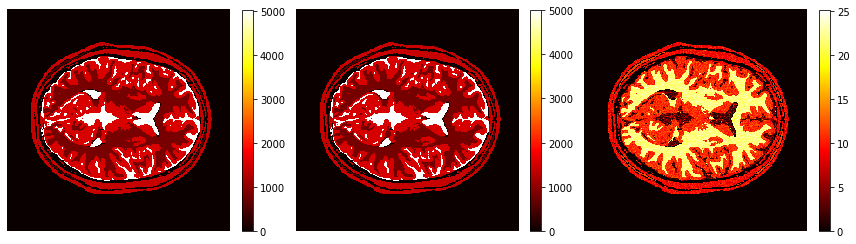

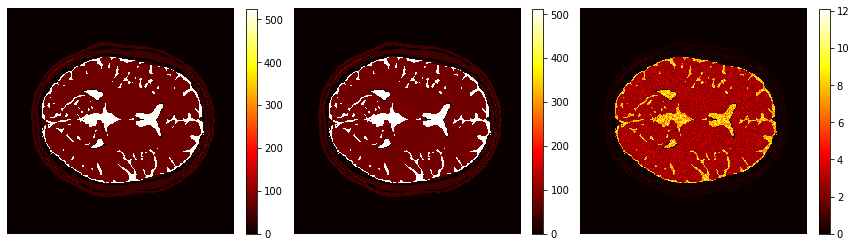

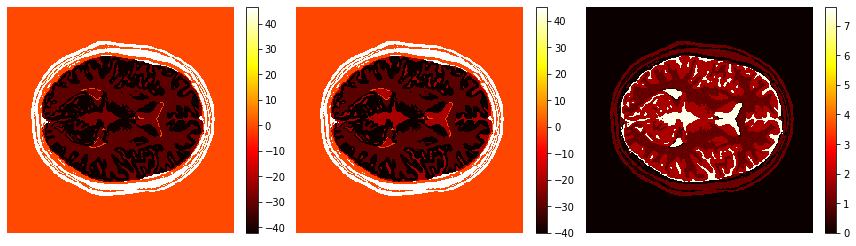

In [ ]:
#Testing
#model = load_model('/content/drive/My Drive/Colab Notebooks/saved_model/model_DRONE_2.h5', custom_objects={'t1_MAPE':t1_MAPE, 't2_MAPE':t2_MAPE, 'rf_MAPE': rf_MAPE, 't1_MAE':t1_MAE, 't2_MAE':t2_MAE, 'rf_MAE':rf_MAE, 't1_accuracy':t1_accuracy, 't2_accuracy':t2_accuracy, 'rf_accuracy':rf_accuracy, 't1_RMSE':t1_RMSE, 't2_RMSE':t2_RMSE, 'rf_RMSE':rf_RMSE})

y_predicted = model.predict([X1_test, X2_test], verbose=1) 
plot_true_v_predicted(y_test, y_predicted)
show_prediction_metrics(y_test, y_predicted, parameters = 3)

y_predicted = make_brain_predictions(brain_noise(phantom_re), brain_noise(phantom_im), model, 3)
y_predicted = mask_brain(y_predicted)
show_brain(y_predicted, np.array([phantom_t1, phantom_t2, phantom_rf]))
print(brain_accuracy(np.array([phantom_t1, phantom_t2, phantom_rf]).transpose(1, 2, 0), y_predicted))